# Model development
The variables related with the ticket amount (judge, fine amounts, discount),
the geographical position (lat,lon,address,zip_code), and the hearing waiting time will be used as features to distinguish between compliant and non-compliant tickets.

## Including geographical features merged from additional sources

In [45]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [46]:
# dataset with addresses and ticket ids
dfa = pd.read_csv("addresses.csv")
dfa.dropna(inplace=True)
# dataset with lat lon coordinates for different addresses
dflalo = pd.read_csv("latlons.csv")
dflalo.dropna(inplace=True)
# parsing addresses from both dataframes so they have similar format
address_parser = lambda x: x.split(",")[0].strip()
dfa["address"] = dfa["address"].apply(address_parser)
dflalo["address"]  = dflalo["address"].apply(address_parser)


#joining  data sets by address
print("rows in dfa: {}".format(len(dfa)))
df_geoloc = dfa.set_index("address").join(dflalo.set_index("address"),how="left")
#print(len(df_geoloc))
# An address may be appear on several tickets, so we want a dataframe whose index is the ticket id. by taking the mean only the numerical variables (lat lon) remain 
df_geoloc = df_geoloc.groupby("ticket_id").agg("mean")
# we merge the previous dataframe (with index ticket id, and cols (lat,lon) ) with dfa to get again the addresses info
df_geoloc = df_geoloc.merge(dfa,left_index=True,right_index=True)
print("rows after joining by address with latlon df: {}".format(len(df_geoloc)))

#we drop na values just to keep tickets with full info about address, lat and lon.
df_geoloc.dropna(inplace=True)
df_geoloc.set_index("ticket_id",inplace=True)
print("rows (e.g. number of tickets) with merged info (lat,lon, address): {}".format(len(df_geoloc)))
df_geoloc.head(5)

rows in dfa: 311307
rows after joining by address with latlon df: 266319
rows (e.g. number of tickets) with merged info (lat,lon, address): 266316


,lat,lon,address
ticket_id,,,
37070,42.383385,-83.072582,14335 minock
37852,42.383422,-83.072483,4488 freer
38601,42.359916,-83.115051,6575 canton
37472,42.393440,-83.127929,6340 faust
37468,42.389689,-83.134415,6340 faust


In [47]:
#loading dataset:

df = pd.read_csv("train.csv",index_col="ticket_id", encoding = "ISO-8859-1",low_memory=False) 
df1= df[ ["disposition", "fine_amount","discount_amount", "judgment_amount", "compliance"]].copy()

print("initial number of tickets: {}".format(len(df1)))
df1.dropna(inplace=True)
l = len(df1)
print("after droping Nan values: {}".format(l))
df1 = df1.join(df_geoloc,how="left")
df1.dropna(inplace=True)
print("after joinning dataframe with lat,lon info: {} ({:0.1f}%)".format(len(df1), 100*len(df1)/l))

initial number of tickets: 250306
after droping Nan values: 159880
after joinning dataframe with lat,lon info: 138117 (86.4%)


# Feature Engineering

In [48]:
street_parser = lambda x: " ".join( x.split(",")[0].split(" ")[1:]).strip()
df1["street"] = df1["address"].apply(street_parser)
df1["zip_code"] = df1["address"].str.findall('\d+').apply( lambda x: x[0])
#encoding categorical variables:
for i in ["compliance","disposition","zip_code","street","address"]:
    df1[i] = df1[i].astype("category")
df1.head(5)

,disposition,fine_amount,discount_amount,judgment_amount,compliance,lat,lon,address,street,zip_code
ticket_id,,,,,,,,,,
37852,Responsible by Default,250.0,0.0,305.0,0.0,42.383422,-83.072483,4488 freer,freer,4488
42751,Responsible by Default,250.0,0.0,305.0,0.0,42.389290,-83.134006,13902 monte vista,monte vista,13902
42753,Responsible by Default,250.0,0.0,305.0,0.0,42.374155,-83.036099,13902 monte vista,monte vista,13902
37027,Responsible by Default,50.0,0.0,85.0,0.0,42.339391,-83.019373,8549 prairie,prairie,8549
37202,Responsible by Default,3500.0,0.0,3880.0,0.0,42.342550,-83.137853,3705 palmer,palmer,3705


In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138117 entries, 37852 to 284333
Data columns (total 10 columns):
disposition        138117 non-null category
fine_amount        138117 non-null float64
discount_amount    138117 non-null float64
judgment_amount    138117 non-null float64
compliance         138117 non-null category
lat                138117 non-null float64
lon                138117 non-null float64
address            138117 non-null category
street             138117 non-null category
zip_code           138117 non-null category
dtypes: category(5), float64(5)
memory usage: 11.5 MB


## Scaling lat,lon features

- *lat* and *lon* are centered around the mean and then normalized using a `RobustScaler`. It removes the median and scales the data according to the quantile range (IQR), making it more robust to outliers. For latitute and longitude we know that almost all the tickets are placed in the metropolitan area so we can  take and  IQR range rather large: (10%, 90%)


In [50]:
from sklearn.preprocessing import RobustScaler
scalers_pos = {}
for i in ["lat","lon"]:
    si = RobustScaler(quantile_range=(10,90))
    values = si.fit_transform(df1[i].values.reshape(-1, 1)).reshape(-1)
    df1[str('scaled_'+i)] = pd.Series(index=df1[i].index,data=values)
    #df1.pop(i)
    scalers_pos[i] = si

## Encoding  categorical features

The "disposition" variable has only 4 unique values, so we use a **one-hot encoding** strategy to obtain the features:

In [51]:
df1["disposition"] = df1["disposition"].apply(  lambda x: str(x).split("by")[1].strip().lower()  )

In [52]:
disposition_dummies = pd.get_dummies(data=df1["disposition"],prefix="responsible_by")
df1 = pd.concat([ df1.drop(columns="disposition") , disposition_dummies],axis=1)
df1.head(3)

,fine_amount,discount_amount,judgment_amount,compliance,lat,lon,address,street,zip_code,scaled_lat,scaled_lon,responsible_by_deter,responsible_by_admission,responsible_by_default,responsible_by_determination
ticket_id,,,,,,,,,,,,,,,
37852,250.0,0.0,305.0,0.0,42.383422,-83.072483,4488 freer,freer,4488,-0.088188,0.198843,0,0,1,0
42751,250.0,0.0,305.0,0.0,42.389290,-83.134006,13902 monte vista,monte vista,13902,-0.024809,-0.038193,0,0,1,0
42753,250.0,0.0,305.0,0.0,42.374155,-83.036099,13902 monte vista,monte vista,13902,-0.188279,0.339024,0,0,1,0


For  "zip_code" and "street" variables, the number of unique values is rather large, a one-hot encoding would generate way too many features. For them we will use a **binary encoding** technique. It consists first on encoding each value of the categorical variable into integers and then transforming then into binary. Each digit of the binary expression will be a feature.

In [53]:
for i in ["zip_code","street","address"]:
    unique_values = len(df1[i].unique())
    bin_unique_values = bin(unique_values)
    len_bin_unique_values = len(bin_unique_values.split('0b')[1]) +1
    print("Variable {}:\n- {} unique values\n- max. binary representation: {}\n- binary-encoded generated features: {}\n".format(i,unique_values,bin_unique_values,len_bin_unique_values))

Variable zip_code:
- 17666 unique values
- max. binary representation: 0b100010100000010
- binary-encoded generated features: 16

Variable street:
- 1696 unique values
- max. binary representation: 0b11010100000
- binary-encoded generated features: 12

Variable address:
- 64932 unique values
- max. binary representation: 0b1111110110100100
- binary-encoded generated features: 17



In [54]:
#previously: pip3 install category_encoders
import category_encoders as ce
bin_encoder =  ce.BinaryEncoder(cols=["zip_code","street","address"],return_df=True)
df1 = bin_encoder.fit_transform(df1)
df1.columns

Index(['fine_amount', 'discount_amount', 'judgment_amount', 'compliance',
       'lat', 'lon', 'address_0', 'address_1', 'address_2', 'address_3',
       'address_4', 'address_5', 'address_6', 'address_7', 'address_8',
       'address_9', 'address_10', 'address_11', 'address_12', 'address_13',
       'address_14', 'address_15', 'address_16', 'street_0', 'street_1',
       'street_2', 'street_3', 'street_4', 'street_5', 'street_6', 'street_7',
       'street_8', 'street_9', 'street_10', 'street_11', 'zip_code_0',
       'zip_code_1', 'zip_code_2', 'zip_code_3', 'zip_code_4', 'zip_code_5',
       'zip_code_6', 'zip_code_7', 'zip_code_8', 'zip_code_9', 'zip_code_10',
       'zip_code_11', 'zip_code_12', 'zip_code_13', 'zip_code_14',
       'zip_code_15', 'scaled_lat', 'scaled_lon', 'responsible_by_deter',
       'responsible_by_admission', 'responsible_by_default',
       'responsible_by_determination'],
      dtype='object')

## Split dataset for training/cv and test

In [55]:
from sklearn.model_selection import train_test_split
target = 'compliance'
features = df1.columns.drop(target)
X_train, X_test, y_train, y_test = train_test_split(df1[features], df1[target], random_state=0,train_size=0.85)

## Scaling  features related with fines amounts and removing outliers

- The features related with fine amounts are normalized but not center around the mean.  

<IPython.core.display.Javascript object>


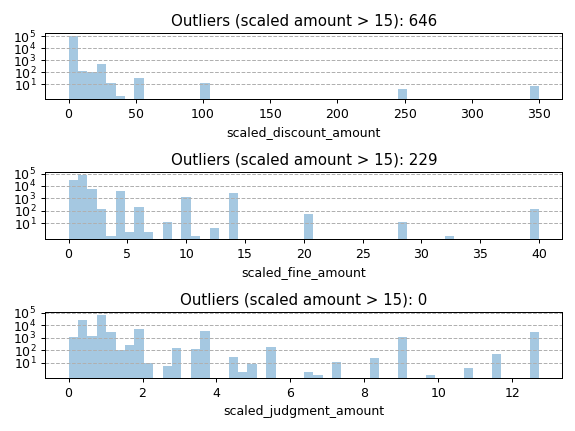

In [56]:
from sklearn.preprocessing import RobustScaler

scalers = {}
for i in ['fine_amount', 'discount_amount', 'judgment_amount']:
    si = RobustScaler(quantile_range=(0,85),with_centering=False)
    values = si.fit_transform(X_train[i].values.reshape(-1, 1)).reshape(-1)
    X_train[str('scaled_'+i)] = pd.Series(index=X_train[i].index,data=values)
    scalers[i] = si
    
plt.subplots(3,1)
for i,j in enumerate(['scaled_discount_amount', 'scaled_fine_amount', 'scaled_judgment_amount']):
    plt.subplot(3,1,i+1)
    sns.distplot(X_train[j],kde=False,norm_hist=False)
    plt.gca().set_yscale("log")
    plt.grid(linestyle='--',axis="y")
    plt.gca().set_yticks([1e1,1e2,1e3,1e4,1e5])
    plt.tight_layout()
    outliers = X_train[j].where( X_train[j]>15).dropna()
    plt.title("Outliers (scaled amount > 15): {}".format( outliers.count() ) )
    #dropping outliers
    X_train.drop(index=outliers.index,inplace=True)

### Outliers in geographical distribution (Remote points) 

All the data points with a lat-lot distance > 2 from the origin are dropped for the training:

In [57]:
origin_distance = lambda  x: np.sqrt( x["scaled_lat"]*x["scaled_lat"] + x["scaled_lon"]*x["scaled_lon"] )
outliers = X_train.where( X_train.apply(origin_distance,axis=1) > 2 )
outliers.dropna(inplace=True)
print("compliance values for outliers: {}".format(y_train.loc[outliers.index].unique()))

compliance values for outliers: [0.0]
Categories (1, float64): [0.0]


<IPython.core.display.Javascript object>


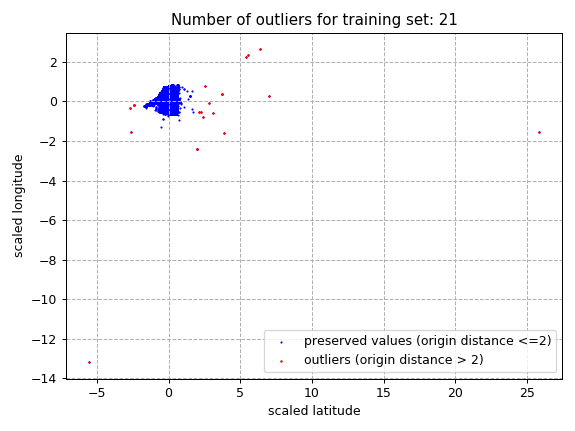

In [58]:
plt.figure()
plt.scatter(X_train.scaled_lat,X_train.scaled_lon,marker='o',c="b",s=0.5,label="preserved values (origin distance <=2)")
plt.scatter(outliers.scaled_lat,outliers.scaled_lon,marker='*',c="r",s=1,label="outliers (origin distance > 2)")
plt.xlabel("scaled latitude")
plt.ylabel("scaled longitude")
plt.title("Number of outliers for training set: {}".format(outliers.count().unique()[0]   ))
plt.grid(linestyle='--')
plt.legend(loc="lower right")
plt.tight_layout()

In [60]:
X_train.drop(index=outliers.index,inplace=True)
y_train.drop(index=outliers.index,inplace=True)
X_train.drop(columns=["lat","lon","fine_amount","discount_amount","judgment_amount"],inplace=True)
X_train.head(3)

,address_0,address_1,address_2,address_3,address_4,address_5,address_6,address_7,address_8,address_9,...,zip_code_15,scaled_lat,scaled_lon,responsible_by_deter,responsible_by_admission,responsible_by_default,responsible_by_determination,scaled_fine_amount,scaled_discount_amount,scaled_judgment_amount
ticket_id,,,,,,,,,,,,,,,,,,,,,
107479,0,0,1,1,1,1,1,0,1,0,...,0,-0.443227,0.014417,0,0,1,0,1.0,0.0,1.0
212619,0,1,1,0,1,1,1,0,0,1,...,1,-0.209708,-0.119384,0,0,1,0,1.0,0.0,1.0
188791,0,1,1,0,1,0,0,1,0,1,...,0,0.368339,-0.383359,0,0,1,0,1.0,0.0,1.0


## Dataset with final features:

In [83]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 116503 entries, 107479 to 116671
Data columns (total 54 columns):
address_0                       116503 non-null int64
address_1                       116503 non-null int64
address_2                       116503 non-null int64
address_3                       116503 non-null int64
address_4                       116503 non-null int64
address_5                       116503 non-null int64
address_6                       116503 non-null int64
address_7                       116503 non-null int64
address_8                       116503 non-null int64
address_9                       116503 non-null int64
address_10                      116503 non-null int64
address_11                      116503 non-null int64
address_12                      116503 non-null int64
address_13                      116503 non-null int64
address_14                      116503 non-null int64
address_15                      116503 non-null int64
address_16          

# Model development

In [84]:
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def plot_cross_validation_results(parameters,grid_search,saveplot=""):
    n = len(parameters)
    fig, _ = plt.subplots(n-1,n-1,figsize=(1.8*n,1.8*n),sharex='col',sharey='row')    
    hyper_param = [i.split("__")[-1] for i in parameters.keys()]    
    cv_res = pd.DataFrame(grid_search.cv_results_)
    name_formater = lambda i: 'param_'+ list(parameters.keys())[i]
    
    for i in range(n):
        for j in range(n):
            if j>=i: continue
            cv_pvt = pd.pivot_table(cv_res, values='mean_test_score',index= name_formater(i), columns=name_formater(j))
            z = (i-1)*(n-1) + (j+1)
            ax = plt.subplot(n-1,n-1,z)
            sns.heatmap(cv_pvt,annot=True,cbar=False,vmin=0,vmax=1.0,cmap="cividis",linewidths=.005)
            if i<n-1: ax.get_xaxis().set_visible(False)
            else: ax.set_xlabel(hyper_param[j])
            if j>0: ax.get_yaxis().set_visible(False)
            else: ax.set_ylabel(hyper_param[i])
    plt.subplots_adjust(left=.06,right=.97,top=0.95,bottom=0.11,wspace=0.04,hspace=0.04)
    plt.tight_layout()  
    if saveplot !="":
        plt.savefig("./cv_{}.png".format(saveplot),format='png')
    return

In [85]:
# preliminary grid search with ~10% of data to see performance and computing times
xt= X_train.iloc[:15000]
yt= y_train.iloc[:15000]

/home/cesarliz10/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


<IPython.core.display.Javascript object>


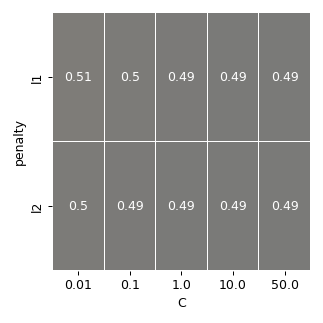

CPU times: user 823 ms, sys: 623 ms, total: 1.45 s
Wall time: 11.4 s


In [86]:
%%time
logic_reg = LogisticRegression()
grid_values = {'C': [1e-2,1e-1, 1, 10, 50], 'penalty':['l1','l2']}
grid_clf = GridSearchCV(logic_reg,param_grid=grid_values,scoring='roc_auc',cv=3, n_jobs=-1)
grid_clf.fit(xt, yt)
plot_cross_validation_results(parameters=grid_values,grid_search=grid_clf)

In [79]:
# SVM, nn 
# plot highest coefficients for model
# plot decision function, previous apply and PCA
SVC?

In [88]:
%%time
svc = SVC(gamma='scale')
grid_values = {'C': [1e-1, 1, 10 ],'kernel':['linear','rbf']} #,'class_weight':['balanced', {1:0.07},{0:1}]}
grid_clf = GridSearchCV(svc,grid_values,scoring='roc_auc',cv=3, n_jobs=-1)
grid_clf.fit(xt, yt)

CPU times: user 2.54 s, sys: 149 ms, total: 2.69 s
Wall time: 11min 52s


<IPython.core.display.Javascript object>


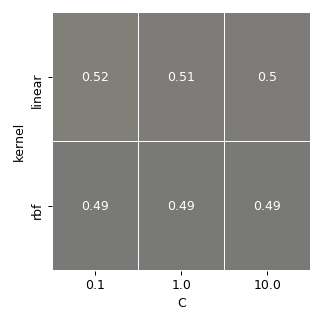

In [89]:
plot_cross_validation_results(parameters=grid_values,grid_search=grid_clf)


In [ ]:
    ################### preparing test set 
    df_cv = pd.read_csv("test.csv",index_col="ticket_id", encoding = "ISO-8859-1")
    df1_cv = df_cv[ vars_for_model[:-1] ]
    df1_cv["disposition"] = df1_cv["disposition"].astype("category")
    df1_cv = pd.get_dummies(df1_cv,prefix="disposition",columns=["disposition"])
    df1_cv["fine_amount"].fillna(0)
    df1_cv = df1_cv[ features ]

    ################### predictions
    index_cv = df1_cv.index
    X_cv = df1_cv.values 
    X_cv_scaled = scaler.transform(X_cv)
    y_cv_prob   = grid_clf.predict_proba(X_cv_scaled)
    y_cv_prob   = y_cv_prob[:,1]
    
    return pd.Series(data=y_cv_prob,index=index_cv)